# AMLD 2021

> ##### Machine Learning in Science: Encoding physical constraints and good development practices


## Example 04 - A physics-guided multi-target neural network

In this notebook, we demonstrate a method for encouraging physical consistency of predictions by neural networks. We start by demonstrating how the loss function can be modified to penalize physics violations in a single-target regressor. We then extend this method to a multi-target regressor to show how the loss function can be modified to penalize violations of conservation laws.

### Workshop Organizers

* Dr. Maria Han Veiga (University of Michigan, USA)

* Dr. Miles Timpe (University of Zurich, Switzerland)

### Import libraries

In [1]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import r2_score


# Global seed value
seed = 42

# Set random seeds
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


# Versions can also influence reproducibility
from sys import version
print(f"Python version: {version}")

Python version: 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


### Load test data and scalers

We focus first on lr_mass.

In [2]:
target = 'lr_mass'

features = ['mtotal', 'gamma', 'b_inf', 'v_inf',
            'targ_core_fraction', 'targ_omega', 'targ_theta', 'targ_phi',
            'proj_core_fraction', 'proj_omega', 'proj_theta', 'proj_phi',
            target]

x_train = pd.read_csv('../datasets/train.csv', usecols=features)
x_test  = pd.read_csv('../datasets/test.csv', usecols=features)

x_train = x_train[x_train['lr_mass'] > 0]
x_test = x_test[x_test['lr_mass'] > 0]

if target != 'lr_mass':
    x_train.pop('lr_mass')
    x_test.pop('lr_mass')

y_train = x_train.pop(target)
y_test  = x_test.pop(target)


# Load scalers and scale targets
y_scaler = load(f"../models/y_scaler_{target}.joblib")

scaled_y_train = y_scaler.transform(y_train.values.reshape(-1, 1))
scaled_y_test  = y_scaler.transform(y_test.values.reshape(-1, 1))
    
# Scale features
x_scaler = load(f"../models/x_scaler.joblib")

scaled_x_train = pd.DataFrame(x_scaler.transform(x_train), columns=x_train.columns)
scaled_x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns)

### Setup physics informed neural network

Here, we will first focus on the 'lr_mass' target

In [3]:
# Define model (MLP) using Keras
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Subtract, Lambda, add, ReLU
from keras.callbacks import EarlyStopping

target = 'lr_mass'

_, input_size = scaled_x_train.shape

# Load previously trained model with no knowledge of physical constraints
model_uninformed = keras.models.load_model(f"../models/regressor_mlp_{target}.keras")

# This particular model will predict scaled target values
y_pred_naive = model_uninformed.predict(scaled_x_test)

# Apply inverse scaling to the model predictions
y_scaler = load(f"../models/y_scaler_{target}.joblib")

y_pred_naive = pd.Series(y_scaler.inverse_transform(y_pred_naive.flatten()), name='y_pred').values

## How do we encode the constraint?

We want to penalise the model if the prediction of 'lr_mass' is larger than 'mtot'.   

This means, if the quantity (lr_mass - mtot) is positive, then we are generating mass.   

We can use a ReLU on this quantity, this way, if this quantity is positive, it will contribute to the loss. If this quantity is 0 or negative, lr_mass is smaller than mtot and it does not contribute to the loss.


$$ ReLU(m_{lr}, m_{tot}) = \left\{
\begin{array}{ll}
      -m_{lr} & \text{for} \quad m_{lr} < 0 \\
      0 & \text{for} \quad 0 \leq m_{lr} \leq m_{tot} \\
      m_{lr} - m_{tot} & \text{for} \quad m_{lr } > m_{tot}
\end{array} \right. $$

In [7]:
# Define model (MLP) using Keras
from keras import backend as K
import tensorflow as tf
import sys

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


# Define custom loss function
def custom_loss_wrapper(input_tensor, overshoot_weight=0.5,positivity_weight=0.5):
    @tf.autograph.experimental.do_not_convert
    def custom_loss(y_true,y_pred):
        s1 = input_tensor[:,0] 
        overshoot = K.mean(ReLU()(Lambda(lambda x: x)(Subtract()([y_pred,s1]))))
        positivity = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred)))
        return keras.losses.mean_squared_error(y_true, y_pred) + overshoot_weight*overshoot\
                + positivity_weight*positivity
    return custom_loss


# Define model
inputs = Input(shape=(input_size,))
f = Dense(24,activation='relu')(inputs)
f = Dense(24,activation='relu')(f)
f = Dense(24,activation='relu')(f)
outputs = Dense(1)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss=custom_loss_wrapper(inputs), metrics=["mse"])


# Fit model
model.fit(x_train, y_train, validation_split=0.05, epochs=500,
          callbacks=[EarlyStopping(patience=70)], verbose=0)

# Make predictions
y_pred_phys = model.predict(x_test)


# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test, y_pred_phys)

# Save the model with keras
model.save(f"../models/regressor_mlp_customloss_{target}.keras")

print(f"Prediction r2_score: {r2:.4f}")

/Users/seriousmaria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Prediction r2_score: 0.9479


### Correlation plots for single-target regressor

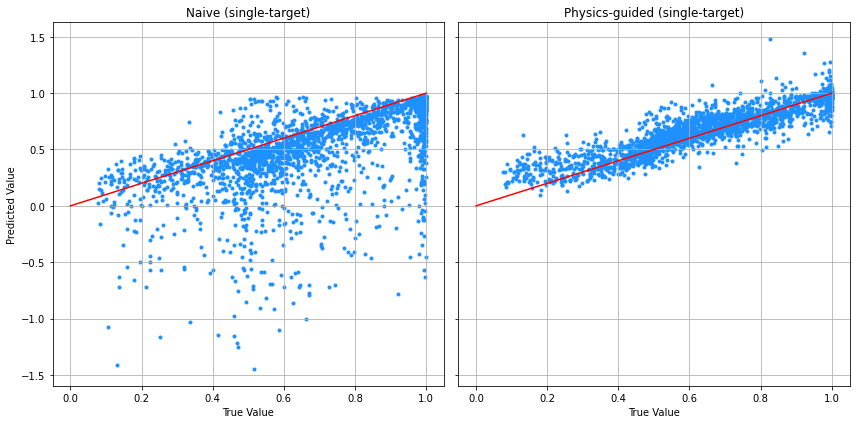

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)


y_test_norm = []
y_naive_norm = []
y_phys_norm = []

for m_tot, y_t, y_p, y_c in zip(x_test.mtotal, y_test, y_pred_naive, y_pred_phys):
    y_test_norm.append( y_t / m_tot )
    y_naive_norm.append( y_p / m_tot )
    y_phys_norm.append( y_c / m_tot )
    

ax = axes[0]

ax.set_title('Naive (single-target)')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')

ax.grid(True)

ax.scatter(y_test_norm, y_naive_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


ax = axes[1]

ax.set_title('Physics-guided (single-target)')
ax.set_xlabel('True Value')

ax.grid(True)

ax.scatter(y_test_norm, y_phys_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')

plt.tight_layout()

In [9]:
#fig, ax = plt.subplots(1, 1, figsize=(8,8))

#ax.set_title('Physics-guided single-target regressor')
#ax.set_xlabel('True Values')
#ax.set_ylabel('Predicted Values')

#plt.plot(y_test, y_pred,ls="None",marker='.')
#plt.plot(x_test['mtotal'].values, y_pred, ls="None",marker='.')
#plt.plot(y_test, y_pred_naive,ls="None",marker='.')
#plt.plot(x_test['mtotal'].values, y_pred_naive, ls="None",marker='.')

#plt.tight_layout()

## Conservation laws with multi-target regressors

Now, we want to predict all masses at the same time, and ensure consistency with the input.

We want to set up a model which will predict the three mass quantities together, and guarantee conservation of mass.

$$ \mathcal{M}(\vec{x}) = \vec{m}, \quad \vec{m} = (m_{lr}, m_{slr}, m_{debris}) $$

under the constraint that

$$ m_{tot} = m_{lr} + m_{slr} + m_{debris} $$

### Load data

Note that we don't scale the features or targets in this case. We could do this, but it would require a bit of extra work within the loss function to apply the inverse scalers to the masses in order to compute the proper sum of the masses. In this case, we have decided to operate on the unscaled data in order to keep things simple and readable.

In [10]:
targets = ['lr_mass','slr_mass','debris_mass']

features = ['mtotal', 'gamma', 'b_inf', 'v_inf',
            'targ_core_fraction', 'targ_omega', 'targ_theta', 'targ_phi',
            'proj_core_fraction', 'proj_omega', 'proj_theta', 'proj_phi'
           ] + targets

x_train = pd.read_csv('../datasets/train.csv', usecols=features)
x_test  = pd.read_csv('../datasets/test.csv', usecols=features)

x_train = x_train[x_train['lr_mass'] > 0]
x_test  = x_test[x_test['lr_mass'] > 0]

y_train = x_train[targets].copy()
y_test  = x_test[targets].copy()

x_train = x_train.drop(targets, axis=1)
x_test  = x_test.drop(targets, axis=1)

### Set up naive multi-target regressor

In [14]:
# Define model
inputs = Input(shape=(input_size,))
f = Dense(24,activation='relu')(inputs)
f = Dense(24,activation='relu')(f)
f = Dense(24,activation='relu')(f)
outputs = Dense(3)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss="mse", metrics=["mse"])

print('fitting')

# Fit model
model.fit(x_train, y_train, validation_split=0.05, epochs=500,
          callbacks=[EarlyStopping(patience=70)], verbose=0)

# Make predictions
y_pred_naive = model.predict(x_test)


# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test.values, y_pred_naive, multioutput="raw_values")

print(r2)

fitting
Train on 9085 samples, validate on 479 samples
Epoch 1/500
9085/9085 [==============================] - 0s 51us/sample - loss: 64.0107 - mse: 64.0106 - val_loss: 1.6792 - val_mse: 1.6792
Epoch 2/500
2112/9085 [=====>........................] - ETA: 0s - loss: 1.4642 - mse: 1.4642

/Users/seriousmaria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


9085/9085 [==============================] - 0s 25us/sample - loss: 1.0648 - mse: 1.0648 - val_loss: 0.6891 - val_mse: 0.6891
Epoch 3/500
9085/9085 [==============================] - 0s 32us/sample - loss: 0.5538 - mse: 0.5538 - val_loss: 0.4544 - val_mse: 0.4544
Epoch 4/500
9085/9085 [==============================] - 1s 61us/sample - loss: 0.4010 - mse: 0.4010 - val_loss: 0.3518 - val_mse: 0.3518
Epoch 5/500
9085/9085 [==============================] - 0s 31us/sample - loss: 0.3255 - mse: 0.3255 - val_loss: 0.2932 - val_mse: 0.2932
Epoch 6/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.2765 - mse: 0.2765 - val_loss: 0.2465 - val_mse: 0.2465
Epoch 7/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.2452 - mse: 0.2452 - val_loss: 0.2274 - val_mse: 0.2274
Epoch 8/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.2224 - mse: 0.2224 - val_loss: 0.2084 - val_mse: 0.2084
Epoch 9/500
9085/9085 [=======================

9085/9085 [==============================] - 0s 23us/sample - loss: 0.0444 - mse: 0.0444 - val_loss: 0.0413 - val_mse: 0.0413
Epoch 62/500
9085/9085 [==============================] - 0s 27us/sample - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 63/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0415 - mse: 0.0415 - val_loss: 0.0447 - val_mse: 0.0447
Epoch 64/500
9085/9085 [==============================] - 0s 26us/sample - loss: 0.0422 - mse: 0.0422 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 65/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 66/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0503 - val_mse: 0.0503
Epoch 67/500
9085/9085 [==============================] - 0s 26us/sample - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 68/500
9085/9085 [================

Epoch 120/500
9085/9085 [==============================] - 0s 21us/sample - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 121/500
9085/9085 [==============================] - 0s 21us/sample - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 122/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 123/500
9085/9085 [==============================] - 0s 21us/sample - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 124/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 125/500
9085/9085 [==============================] - 0s 21us/sample - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 126/500
9085/9085 [==============================] - 0s 20us/sample - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 127/500
9085/9

9085/9085 [==============================] - 0s 20us/sample - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 179/500
9085/9085 [==============================] - 0s 21us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 180/500
9085/9085 [==============================] - 0s 21us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 181/500
9085/9085 [==============================] - 0s 30us/sample - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 182/500
9085/9085 [==============================] - 0s 27us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 183/500
9085/9085 [==============================] - 0s 31us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 184/500
9085/9085 [==============================] - 0s 31us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 185/500
9085/9085 [=========

9085/9085 [==============================] - 0s 23us/sample - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 237/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 238/500
9085/9085 [==============================] - 0s 27us/sample - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 239/500
9085/9085 [==============================] - 0s 26us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 240/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 241/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 242/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 243/500
9085/9085 [=========

9085/9085 [==============================] - 0s 54us/sample - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 295/500
9085/9085 [==============================] - 0s 43us/sample - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 296/500
9085/9085 [==============================] - 0s 31us/sample - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 297/500
9085/9085 [==============================] - 0s 28us/sample - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 298/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 299/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 300/500
9085/9085 [==============================] - 0s 25us/sample - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 301/500
9085/9085 [=========

9085/9085 [==============================] - 0s 20us/sample - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 353/500
9085/9085 [==============================] - 0s 20us/sample - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 354/500
9085/9085 [==============================] - 0s 20us/sample - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 355/500
9085/9085 [==============================] - 0s 25us/sample - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 356/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 357/500
9085/9085 [==============================] - 0s 21us/sample - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 358/500
9085/9085 [==============================] - 0s 20us/sample - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 359/500
9085/9085 [=========

9085/9085 [==============================] - 0s 21us/sample - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 411/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 412/500
9085/9085 [==============================] - 0s 26us/sample - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 413/500
9085/9085 [==============================] - 0s 27us/sample - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 414/500
9085/9085 [==============================] - 0s 28us/sample - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 415/500
9085/9085 [==============================] - 0s 29us/sample - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 416/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 417/500
9085/9085 [=========

9085/9085 [==============================] - 0s 23us/sample - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 469/500
9085/9085 [==============================] - 0s 21us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 470/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 471/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 472/500
9085/9085 [==============================] - 0s 20us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 473/500
9085/9085 [==============================] - 0s 20us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 474/500
9085/9085 [==============================] - 0s 20us/sample - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 475/500
9085/9085 [=========

### Physics-guided multi-target regressor

We now attempt to impose knowledge of mass conservation on our model. In order to acheive this, we need to predict all three masses simultaneously using a multi-target regressor. We will still use the same 12 input features, but this time we will be predicting three output targets.

In [15]:
# Define model (MLP) using Keras
from keras import backend as K
import tensorflow as tf
import sys

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()


# Define custom loss function
def custom_loss_wrapper(input_tensor, overshoot_weight=0.5,positivity_weight=0.5):
    @tf.autograph.experimental.do_not_convert
    def custom_loss(y_true,y_pred):
        s1 = input_tensor[:,0]
        sum_of_mass = K.sum(y_pred,axis=1)
        overshoot = K.mean(ReLU()(Lambda(lambda x: x)(Subtract()([sum_of_mass,s1]))))
        positivity_lr = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred[:,0])))
        positivity_slr = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred[:,1])))
        positivity_debris = K.mean(ReLU()(Lambda(lambda x: -x)(y_pred[:,2])))
        return keras.losses.mean_squared_error(y_true, y_pred) + overshoot_weight*overshoot\
                + positivity_weight*(positivity_lr + positivity_slr + positivity_debris)
    return custom_loss


# Define model
inputs = Input(shape=(input_size,))
f = Dense(24,activation='relu')(inputs)
f = Dense(24,activation='relu')(f)
f = Dense(24,activation='relu')(f)
outputs = Dense(3)(f)

model = keras.Model(inputs, outputs)

model.compile('Adam', loss=custom_loss_wrapper(inputs), metrics=["mse"])


# Fit model
model.fit(x_train, y_train, validation_split=0.05, epochs=500,
          callbacks=[EarlyStopping(patience=70)], verbose=0)

# Make predictions
y_pred_phys = model.predict(x_test)


# Calculate the quality of the predictions with the r2 score
r2 = r2_score(y_test, y_pred_phys, multioutput="raw_values")

for i, name in enumerate(targets):
    print(f"{name:>20}\t{r2[i]:.4f}")

# Save the model with keras
model.save(f"../models/regressor_mlp_customloss_{target}.keras")

Train on 9085 samples, validate on 479 samples
Epoch 1/500
9085/9085 [==============================] - 0s 50us/sample - loss: 34.9316 - mse: 32.3269 - val_loss: 2.4925 - val_mse: 1.7246
Epoch 2/500
1760/9085 [====>.........................] - ETA: 0s - loss: 2.2012 - mse: 1.5212

/Users/seriousmaria/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


9085/9085 [==============================] - 0s 31us/sample - loss: 1.6479 - mse: 1.1058 - val_loss: 1.1539 - val_mse: 0.7319
Epoch 3/500
9085/9085 [==============================] - 0s 28us/sample - loss: 0.8417 - mse: 0.5244 - val_loss: 0.6740 - val_mse: 0.4085
Epoch 4/500
9085/9085 [==============================] - 0s 28us/sample - loss: 0.5252 - mse: 0.3260 - val_loss: 0.4886 - val_mse: 0.2993
Epoch 5/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.4135 - mse: 0.2601 - val_loss: 0.3920 - val_mse: 0.2535
Epoch 6/500
9085/9085 [==============================] - 0s 25us/sample - loss: 0.3438 - mse: 0.2200 - val_loss: 0.3334 - val_mse: 0.2154
Epoch 7/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.3033 - mse: 0.1970 - val_loss: 0.3038 - val_mse: 0.1963
Epoch 8/500
9085/9085 [==============================] - 0s 25us/sample - loss: 0.2768 - mse: 0.1809 - val_loss: 0.2612 - val_mse: 0.1748
Epoch 9/500
9085/9085 [=======================

9085/9085 [==============================] - 0s 50us/sample - loss: 0.0721 - mse: 0.0655 - val_loss: 0.0692 - val_mse: 0.0661
Epoch 62/500
9085/9085 [==============================] - 0s 41us/sample - loss: 0.0682 - mse: 0.0631 - val_loss: 0.0747 - val_mse: 0.0702
Epoch 63/500
9085/9085 [==============================] - 0s 28us/sample - loss: 0.0747 - mse: 0.0662 - val_loss: 0.0698 - val_mse: 0.0657
Epoch 64/500
9085/9085 [==============================] - 0s 27us/sample - loss: 0.0703 - mse: 0.0638 - val_loss: 0.0767 - val_mse: 0.0667
Epoch 65/500
9085/9085 [==============================] - 0s 27us/sample - loss: 0.0675 - mse: 0.0614 - val_loss: 0.0685 - val_mse: 0.0651
Epoch 66/500
9085/9085 [==============================] - 0s 28us/sample - loss: 0.0681 - mse: 0.0606 - val_loss: 0.0735 - val_mse: 0.0676
Epoch 67/500
9085/9085 [==============================] - 0s 25us/sample - loss: 0.0666 - mse: 0.0590 - val_loss: 0.0687 - val_mse: 0.0621
Epoch 68/500
9085/9085 [================

Epoch 120/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0230 - mse: 0.0209 - val_loss: 0.0188 - val_mse: 0.0180
Epoch 121/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0227 - mse: 0.0205 - val_loss: 0.0203 - val_mse: 0.0187
Epoch 122/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0232 - mse: 0.0209 - val_loss: 0.0198 - val_mse: 0.0189
Epoch 123/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0249 - mse: 0.0226 - val_loss: 0.0263 - val_mse: 0.0251
Epoch 124/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0222 - mse: 0.0203 - val_loss: 0.0223 - val_mse: 0.0176
Epoch 125/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0209 - mse: 0.0190 - val_loss: 0.0208 - val_mse: 0.0194
Epoch 126/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0213 - mse: 0.0194 - val_loss: 0.0213 - val_mse: 0.0205
Epoch 127/500
9085/9

9085/9085 [==============================] - 0s 33us/sample - loss: 0.0134 - mse: 0.0121 - val_loss: 0.0101 - val_mse: 0.0096
Epoch 179/500
9085/9085 [==============================] - 0s 25us/sample - loss: 0.0128 - mse: 0.0116 - val_loss: 0.0105 - val_mse: 0.0095
Epoch 180/500
9085/9085 [==============================] - 0s 28us/sample - loss: 0.0121 - mse: 0.0111 - val_loss: 0.0206 - val_mse: 0.0198
Epoch 181/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0132 - mse: 0.0122 - val_loss: 0.0123 - val_mse: 0.0121
Epoch 182/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0118 - mse: 0.0110 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 183/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0117 - mse: 0.0109 - val_loss: 0.0085 - val_mse: 0.0073
Epoch 184/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0117 - mse: 0.0109 - val_loss: 0.0143 - val_mse: 0.0141
Epoch 185/500
9085/9085 [=========

9085/9085 [==============================] - 0s 25us/sample - loss: 0.0094 - mse: 0.0090 - val_loss: 0.0073 - val_mse: 0.0071
Epoch 237/500
9085/9085 [==============================] - 0s 25us/sample - loss: 0.0089 - mse: 0.0085 - val_loss: 0.0073 - val_mse: 0.0062
Epoch 238/500
9085/9085 [==============================] - 0s 28us/sample - loss: 0.0085 - mse: 0.0080 - val_loss: 0.0053 - val_mse: 0.0051
Epoch 239/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0096 - mse: 0.0089 - val_loss: 0.0067 - val_mse: 0.0066
Epoch 240/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0090 - mse: 0.0087 - val_loss: 0.0072 - val_mse: 0.0070
Epoch 241/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0078 - mse: 0.0074 - val_loss: 0.0132 - val_mse: 0.0128
Epoch 242/500
9085/9085 [==============================] - 0s 25us/sample - loss: 0.0090 - mse: 0.0084 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 243/500
9085/9085 [=========

9085/9085 [==============================] - 0s 25us/sample - loss: 0.0069 - mse: 0.0066 - val_loss: 0.0054 - val_mse: 0.0053
Epoch 295/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0074 - mse: 0.0069 - val_loss: 0.0044 - val_mse: 0.0036
Epoch 296/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0069 - mse: 0.0066 - val_loss: 0.0054 - val_mse: 0.0053
Epoch 297/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0060 - mse: 0.0058 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 298/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0095 - mse: 0.0090 - val_loss: 0.0123 - val_mse: 0.0091
Epoch 299/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0071 - mse: 0.0068 - val_loss: 0.0059 - val_mse: 0.0058
Epoch 300/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0067 - mse: 0.0064 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 301/500
9085/9085 [=========

9085/9085 [==============================] - 0s 26us/sample - loss: 0.0073 - mse: 0.0069 - val_loss: 0.0054 - val_mse: 0.0053
Epoch 353/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0062 - mse: 0.0059 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 354/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0060 - mse: 0.0057 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 355/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0058 - mse: 0.0056 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 356/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0065 - mse: 0.0062 - val_loss: 0.0040 - val_mse: 0.0039
Epoch 357/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0065 - mse: 0.0061 - val_loss: 0.0038 - val_mse: 0.0037
Epoch 358/500
9085/9085 [==============================] - 0s 24us/sample - loss: 0.0067 - mse: 0.0063 - val_loss: 0.0037 - val_mse: 0.0036
Epoch 359/500
9085/9085 [=========

9085/9085 [==============================] - 0s 23us/sample - loss: 0.0060 - mse: 0.0058 - val_loss: 0.0077 - val_mse: 0.0030
Epoch 411/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0057 - mse: 0.0054 - val_loss: 0.0054 - val_mse: 0.0053
Epoch 412/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0061 - mse: 0.0058 - val_loss: 0.0073 - val_mse: 0.0072
Epoch 413/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0069 - mse: 0.0066 - val_loss: 0.0100 - val_mse: 0.0099
Epoch 414/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0065 - mse: 0.0062 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 415/500
9085/9085 [==============================] - 0s 23us/sample - loss: 0.0053 - mse: 0.0052 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 416/500
9085/9085 [==============================] - 0s 22us/sample - loss: 0.0055 - mse: 0.0053 - val_loss: 0.0035 - val_mse: 0.0034
Epoch 417/500
9085/9085 [=========

9085/9085 [==============================] - 0s 26us/sample - loss: 0.0054 - mse: 0.0052 - val_loss: 0.0051 - val_mse: 0.0050
Epoch 469/500
9085/9085 [==============================] - 0s 26us/sample - loss: 0.0050 - mse: 0.0047 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 470/500
9085/9085 [==============================] - 0s 30us/sample - loss: 0.0052 - mse: 0.0050 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 471/500
9085/9085 [==============================] - 0s 31us/sample - loss: 0.0054 - mse: 0.0051 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 472/500
9085/9085 [==============================] - 1s 60us/sample - loss: 0.0057 - mse: 0.0055 - val_loss: 0.0066 - val_mse: 0.0065
Epoch 473/500
9085/9085 [==============================] - 0s 28us/sample - loss: 0.0051 - mse: 0.0049 - val_loss: 0.0036 - val_mse: 0.0034
Epoch 474/500
9085/9085 [==============================] - 0s 26us/sample - loss: 0.0054 - mse: 0.0052 - val_loss: 0.0039 - val_mse: 0.0038
Epoch 475/500
9085/9085 [=========

### Mass residual histogram

[1737.6099   352.61774  556.8931 ]


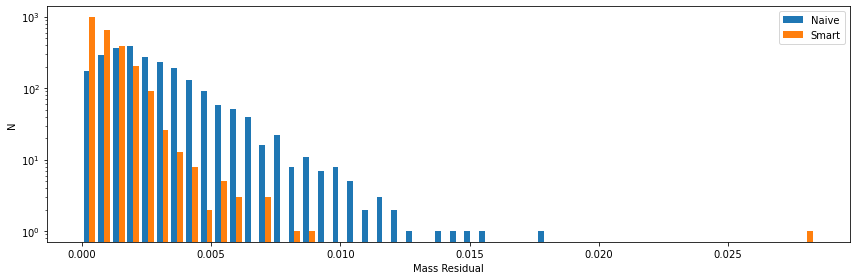

In [16]:
print(np.sum(y_pred_naive, axis=0))

mtot_est_naive = np.sum(y_pred_naive, axis=1)
residual_naive = (x_test.values[:,0] - mtot_est_naive)**2.

mtot_est_phys = np.sum(y_pred_phys, axis=1)
residual_phys = (x_test.values[:,0] - mtot_est_phys)**2.

fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.hist([residual_naive, residual_phys], bins=50, label=['Naive', 'Smart'])

ax.set_xlabel('Mass Residual')

ax.set_ylabel('N')
ax.set_yscale('log')

ax.legend()

plt.tight_layout()